In [31]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time, os
import sys
import re
import string
import nltk

import pickle
import random

from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wentingdeng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [834]:
with open('df.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14187 entries, 0 to 14186
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           14187 non-null  object
 1   product_name         14187 non-null  object
 2   product_description  14187 non-null  object
 3   brand_name           14187 non-null  object
 4   review               14187 non-null  object
 5   url                  14187 non-null  object
 6   image_url            14187 non-null  object
 7   department           14187 non-null  object
dtypes: object(8)
memory usage: 886.8+ KB


In [3]:
df = df[df['product_name'] != 'Missing']

In [4]:
df['brand_name'].value_counts()

Demeter              358
Swiss Arabian        197
Montale              174
Jo Malone            161
Armaf                141
                    ... 
Chaz Dean              1
Us Army                1
Fragrance Sport        1
Kate Walsh             1
Johnston & Murphy      1
Name: brand_name, Length: 1195, dtype: int64

In [5]:
#drop duplicate values
df.sort_values(['product_name'], inplace = True, ascending = False)

In [6]:
df.drop_duplicates(subset = ['product_name'], inplace = True)

In [7]:
#this sensence isn't relevant to product description
string_to_remove = 'All products are original, authentic name brands. We do not sell knockoffs or imitations.'

df['product_description'] = df['product_description'].apply(lambda x: x.replace(string_to_remove, ""))

In [8]:
#Remove product name and brand_name
def replace_str(str1, str2):
    return str1.replace(str2, '')

In [9]:
df['product_description2'] = df.apply(lambda row: replace_str(row['product_description'], row['product_name']), axis = 1)

In [10]:
df['product_description3'] = df.apply(lambda row: replace_str(row['product_description2'], row['brand_name']), axis = 1)

In [11]:
df.drop(columns = ['product_description', 'product_description2'], inplace = True)
df.rename(columns = {"product_description3": "product_description"}, inplace = True)

In [12]:
df_desc = df.copy()

In [13]:
#Remove punctuations
#Remove numbers
#Change to lowercases

punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation),' ', x.lower())
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
df_desc['product_description'] = df_desc['product_description'].map(punc_lower).map(alphanumeric)


In [14]:
#check average doc length
docs = df_desc["product_description"].tolist()  
word_counts = [len(doc.split()) for doc in docs]
avg_word_count = np.mean(word_counts)

avg_word_count

148.18877867327961

In [15]:
#Tokenize
df_desc['doc'] = df_desc.product_description.apply(lambda x: word_tokenize(x))
df_desc.head()

,product_id,product_name,brand_name,review,url,image_url,department,product_description,doc
11976,perfume_1-am-pid_61804m,Être Pour Homme Cologne,Lancetti,0.0,https://www.fragrancex.com/products/_cid_colog...,Missing,Men's Cologne,by the être pour homme men’s cologne is an ...,"[by, the, être, pour, homme, men, ’, s, cologn..."
10831,perfume_z-am-pid_66892m,Zozo Cologne,Ut & C,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by ut c the zo zo collection of perfumes o...,"[by, ut, c, the, zo, zo, collection, of, perfu..."
5213,perfume_z-am-pid_70011w,Zoa Night Perfume,Regines,4.3,https://www.fragrancex.com/products/_cid_perfu...,https://img.fragrancex.com/images/products/par...,Women's Perfume,by feel sexy and fearless as ever while wea...,"[by, feel, sexy, and, fearless, as, ever, whil..."
11044,perfume_z-am-pid_71388m,Zizonia Cologne,Penhaligon's,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by zizonia was originally released in the ...,"[by, zizonia, was, originally, released, in, t..."
13024,perfume_z-am-pid_1384m,Zizanie Cologne,Fragonard,4.4,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by launched by the design house of fragonar...,"[by, launched, by, the, design, house, of, fra..."


In [16]:
#Remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wentingdeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df_desc['doc_rm_sw'] = df_desc['doc'].apply(lambda x: [word for word in x if word not in stopwords_list])

In [18]:
df_desc.drop(columns = ['doc'], inplace = True)
df_desc.rename(columns = {'doc_rm_sw' : 'doc'}, inplace = True)

In [19]:
df_desc['product_description_cleaned'] = df_desc['doc'].apply(lambda x: ' '.join(x))

In [20]:
df_desc = df_desc[df_desc['product_description_cleaned'] != ""]

In [21]:
#check the most frequent words
words_list = [word for doc in df_desc.doc for word in doc]

Counter(words_list).most_common(20)

[('notes', 25462),
 ('fragrance', 25352),
 ('scent', 13480),
 ('perfume', 12529),
 ('’', 12466),
 ('company', 9723),
 ('brand', 8760),
 ('base', 8700),
 ('floral', 8477),
 ('fragrances', 8219),
 ('top', 7599),
 ('women', 6953),
 ('musk', 6673),
 ('heart', 6460),
 ('launched', 5980),
 ('first', 5686),
 ('men', 5604),
 ('released', 5571),
 ('cologne', 5425),
 ('sweet', 5371)]

In [22]:
#check the least frequent words
Counter(words_list).most_common()[-20:]

[('submitted', 1),
 ('pastry', 1),
 ('blustery', 1),
 ('printanier', 1),
 ('nagaranga', 1),
 ('citronne', 1),
 ('bion', 1),
 ('lumineux', 1),
 ('solaire', 1),
 ('soyeux', 1),
 ('carvi', 1),
 ('disposal', 1),
 ('familiarness', 1),
 ('ingot', 1),
 ('ketal', 1),
 ('solange', 1),
 ('dimitrios', 1),
 ('follower', 1),
 ('anticipates', 1),
 ('operative', 1)]

In [23]:
df_desc.head()

,product_id,product_name,brand_name,review,url,image_url,department,product_description,doc,product_description_cleaned
11976,perfume_1-am-pid_61804m,Être Pour Homme Cologne,Lancetti,0.0,https://www.fragrancex.com/products/_cid_colog...,Missing,Men's Cologne,by the être pour homme men’s cologne is an ...,"[être, pour, homme, men, ’, cologne, around, s...",être pour homme men ’ cologne around strong ma...
10831,perfume_z-am-pid_66892m,Zozo Cologne,Ut & C,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by ut c the zo zo collection of perfumes o...,"[ut, c, zo, zo, collection, perfumes, offers, ...",ut c zo zo collection perfumes offers men uniq...
5213,perfume_z-am-pid_70011w,Zoa Night Perfume,Regines,4.3,https://www.fragrancex.com/products/_cid_perfu...,https://img.fragrancex.com/images/products/par...,Women's Perfume,by feel sexy and fearless as ever while wea...,"[feel, sexy, fearless, ever, wearing, lush, sc...",feel sexy fearless ever wearing lush scent dec...
11044,perfume_z-am-pid_71388m,Zizonia Cologne,Penhaligon's,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by zizonia was originally released in the ...,"[zizonia, originally, released, reintroduced, ...",zizonia originally released reintroduced intri...
13024,perfume_z-am-pid_1384m,Zizanie Cologne,Fragonard,4.4,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by launched by the design house of fragonar...,"[launched, design, house, fragonard, zizanie, ...",launched design house fragonard zizanie classi...


#### Base Model

In [24]:
def topic_model(vectorizer, docs, model, no_top_words, topic_names = None):
    #Vectorize
    cv = vectorizer
    doc_words_trans = cv.fit_transform(docs)
    
    #fit the model
    topic_model = model
    doc_topic = topic_model.fit_transform(doc_words_trans)
    
    #print out the topics
    feature_names = cv.get_feature_names()
    for ix, topic in enumerate(topic_model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [25]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_cleaned']
model = NMF(4, random_state= 123)
no_top_words = 10


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
notes, fashion, fragrance, first, brand, floral, company, launched, designer, women

Topic  1
notes, floral, perfume, sweet, scent, aroma, fragrance, accords, rose, white

Topic  2
cologne, men, notes, spicy, masculine, fragrance, woody, lavender, scent, aromatic

Topic  3
company, perfume, fragrance, fragrances, scents, products, brand, scent, note, perfumes


/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [26]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_cleaned']
model = NMF(5, random_state= 123)
no_top_words = 10


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
floral, notes, ylang, rose, fragrance, perfume, sweet, musk, white, jasmine

Topic  1
aroma, accords, elixir, finally, atmosphere, perfume, notes, concoction, combines, seductive

Topic  2
cologne, notes, men, spicy, masculine, woody, fragrance, lavender, scent, aromatic

Topic  3
perfume, fragrance, company, fragrances, note, scent, scents, aroma, bottle, products

Topic  4
fashion, company, brand, first, fragrance, designer, launched, fragrances, notes, began


/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [27]:
vectorizer = TfidfVectorizer(max_df = 7000)
docs = df_desc['product_description_cleaned']
model = NMF(6, random_state= 123)
no_top_words = 10


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
floral, ylang, rose, sweet, white, musk, jasmine, vanilla, heart, warm

Topic  1
aroma, accords, elixir, finally, atmosphere, concoction, combines, seductive, blends, night

Topic  2
cologne, men, spicy, masculine, lavender, woody, aromatic, man, cedar, vetiver

Topic  3
company, brand, products, fragrances, many, perfumes, body, also, founded, scents

Topic  4
fashion, first, designer, launched, brand, line, women, clothing, moderate, released

Topic  5
note, accord, wear, aroma, women, scents, aromas, unique, fragrances, company


#### Continue to clear the text data

In [28]:
#Lementization for dimensionality reduction
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wentingdeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
df_desc.head()

,product_id,product_name,brand_name,review,url,image_url,department,product_description,doc,product_description_cleaned
11976,perfume_1-am-pid_61804m,Être Pour Homme Cologne,Lancetti,0.0,https://www.fragrancex.com/products/_cid_colog...,Missing,Men's Cologne,by the être pour homme men’s cologne is an ...,"[être, pour, homme, men, ’, cologne, around, s...",être pour homme men ’ cologne around strong ma...
10831,perfume_z-am-pid_66892m,Zozo Cologne,Ut & C,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by ut c the zo zo collection of perfumes o...,"[ut, c, zo, zo, collection, perfumes, offers, ...",ut c zo zo collection perfumes offers men uniq...
5213,perfume_z-am-pid_70011w,Zoa Night Perfume,Regines,4.3,https://www.fragrancex.com/products/_cid_perfu...,https://img.fragrancex.com/images/products/par...,Women's Perfume,by feel sexy and fearless as ever while wea...,"[feel, sexy, fearless, ever, wearing, lush, sc...",feel sexy fearless ever wearing lush scent dec...
11044,perfume_z-am-pid_71388m,Zizonia Cologne,Penhaligon's,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by zizonia was originally released in the ...,"[zizonia, originally, released, reintroduced, ...",zizonia originally released reintroduced intri...
13024,perfume_z-am-pid_1384m,Zizanie Cologne,Fragonard,4.4,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by launched by the design house of fragonar...,"[launched, design, house, fragonard, zizanie, ...",launched design house fragonard zizanie classi...


In [32]:
def lemmatize_token(doc):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token,tag) for token, tag in pos_tag(word_tokenize(doc))]

In [67]:
# convert position tags to be WordNetLemmatizer compatible
def lemmatize_token(doc):
    lemmatizer = WordNetLemmatizer()
    
    for word, tag in pos_tag(word_tokenize(doc)):
        if tag.startswith('NN'):
            return lemmatizer.lemmatize(word, pos = 'n')
        elif tag.startswith('NNS'):
            return lemmatizer.lemmatize(word, pos = 'n')
        elif tag.startswith('NP'):
            return lemmatizer.lemmatize(word, pos = 'n')
        elif tag.startswith('JJ'):
            return lemmatizer.lemmatize(word, pos = 'a')
        else:
            return word

In [68]:
df_desc['doc_lemmatizer'] = test.product_description_cleaned.apply(lambda x: [lemmatize_token(word) for word in x.split()])

In [69]:
df_desc.head()

,product_id,product_name,brand_name,review,url,image_url,department,product_description,doc,product_description_cleaned,doc_lemmatizer
11976,perfume_1-am-pid_61804m,Être Pour Homme Cologne,Lancetti,0.0,https://www.fragrancex.com/products/_cid_colog...,Missing,Men's Cologne,by the être pour homme men’s cologne is an ...,"[être, pour, homme, men, ’, cologne, around, s...",être pour homme men ’ cologne around strong ma...,"[être, pour, homme, men, ’, cologne, around, s..."
10831,perfume_z-am-pid_66892m,Zozo Cologne,Ut & C,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by ut c the zo zo collection of perfumes o...,"[ut, c, zo, zo, collection, perfumes, offers, ...",ut c zo zo collection perfumes offers men uniq...,"[ut, c, zo, zo, collection, perfume, offer, me..."
5213,perfume_z-am-pid_70011w,Zoa Night Perfume,Regines,4.3,https://www.fragrancex.com/products/_cid_perfu...,https://img.fragrancex.com/images/products/par...,Women's Perfume,by feel sexy and fearless as ever while wea...,"[feel, sexy, fearless, ever, wearing, lush, sc...",feel sexy fearless ever wearing lush scent dec...,"[feel, sexy, fearless, ever, wearing, lush, sc..."
11044,perfume_z-am-pid_71388m,Zizonia Cologne,Penhaligon's,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by zizonia was originally released in the ...,"[zizonia, originally, released, reintroduced, ...",zizonia originally released reintroduced intri...,"[zizonia, originally, released, reintroduced, ..."
13024,perfume_z-am-pid_1384m,Zizanie Cologne,Fragonard,4.4,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,by launched by the design house of fragonar...,"[launched, design, house, fragonard, zizanie, ...",launched design house fragonard zizanie classi...,"[launched, design, house, fragonard, zizanie, ..."


In [70]:
df_desc.drop(columns = ['doc'], inplace = True)
df_desc.drop(columns = 'product_description_cleaned', inplace = True)

In [71]:
df_desc['product_description_cleaned'] = df_desc['doc_lemmatizer'].apply(lambda x: ' '.join(x))

In [72]:
df_desc.rename(columns = {'doc_lemmatizer' : 'doc'}, inplace = True)

In [73]:
df_desc.drop(columns = 'product_description', inplace = True)
df_desc.head()

,product_id,product_name,brand_name,review,url,image_url,department,doc,product_description_cleaned
11976,perfume_1-am-pid_61804m,Être Pour Homme Cologne,Lancetti,0.0,https://www.fragrancex.com/products/_cid_colog...,Missing,Men's Cologne,"[être, pour, homme, men, ’, cologne, around, s...",être pour homme men ’ cologne around strong ma...
10831,perfume_z-am-pid_66892m,Zozo Cologne,Ut & C,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,"[ut, c, zo, zo, collection, perfume, offer, me...",ut c zo zo collection perfume offer men unique...
5213,perfume_z-am-pid_70011w,Zoa Night Perfume,Regines,4.3,https://www.fragrancex.com/products/_cid_perfu...,https://img.fragrancex.com/images/products/par...,Women's Perfume,"[feel, sexy, fearless, ever, wearing, lush, sc...",feel sexy fearless ever wearing lush scent dec...
11044,perfume_z-am-pid_71388m,Zizonia Cologne,Penhaligon's,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,"[zizonia, originally, released, reintroduced, ...",zizonia originally released reintroduced intri...
13024,perfume_z-am-pid_1384m,Zizanie Cologne,Fragonard,4.4,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,"[launched, design, house, fragonard, zizanie, ...",launched design house fragonard zizanie classi...


In [74]:
#After lemmatization, re-run the NMF model
vectorizer = TfidfVectorizer(max_df = 7000)
docs = df_desc['product_description_cleaned']
model = NMF(6, random_state= 123)
no_top_words = 10


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
floral, ylang, rose, sweet, white, musk, jasmine, vanilla, heart, fruity

Topic  1
aroma, accord, elixir, finally, atmosphere, concoction, seductive, sensual, night, essence

Topic  2
cologne, men, spicy, masculine, lavender, woody, aromatic, cedar, man, vetiver

Topic  3
company, brand, product, many, body, also, founded, one, around, cosmetic

Topic  4
fashion, designer, first, line, brand, launched, design, clothing, woman, released

Topic  5
day, sillage, wear, moderate, long, lasting, longevity, aroma, woman, summer


/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [75]:
# Add some new stop words
stop_word_add = ['company','first','launched','founded','released','line','smell',
                'fragrance','note','perfume','brand','scent','product','name','sell',
                '’','cologne','top','began','men','man','woman','york','american',
                 'many','spray','care','year','day','bottle','state','sure',
                'wear', 'main', 'feature','wear', 'main','feature','store','new',
                 'time','work','perfect','high','cosmetic','skincare','beauty','united',
                'career','bath','lotion','pdc','world','accord','finally']


In [76]:
stopwords_list_add = stopwords_list + stop_word_add

In [77]:
df_desc['doc2'] = df_desc['doc'].apply(lambda x: [token for token in x if token not in stopwords_list_add])

In [78]:
df_desc.drop(columns = ['doc','product_description_cleaned'], inplace = True)
df_desc.rename(columns = {'doc2' : 'doc'}, inplace = True)
df_desc.head()

,product_id,product_name,brand_name,review,url,image_url,department,doc
11976,perfume_1-am-pid_61804m,Être Pour Homme Cologne,Lancetti,0.0,https://www.fragrancex.com/products/_cid_colog...,Missing,Men's Cologne,"[être, pour, homme, around, strong, masculine,..."
10831,perfume_z-am-pid_66892m,Zozo Cologne,Ut & C,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,"[ut, c, zo, zo, collection, offer, unique, exq..."
5213,perfume_z-am-pid_70011w,Zoa Night Perfume,Regines,4.3,https://www.fragrancex.com/products/_cid_perfu...,https://img.fragrancex.com/images/products/par...,Women's Perfume,"[feel, sexy, fearless, ever, wearing, lush, de..."
11044,perfume_z-am-pid_71388m,Zizonia Cologne,Penhaligon's,5.0,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,"[zizonia, originally, reintroduced, intriguing..."
13024,perfume_z-am-pid_1384m,Zizanie Cologne,Fragonard,4.4,https://www.fragrancex.com/products/_cid_colog...,https://img.fragrancex.com/images/products/par...,Men's Cologne,"[design, house, fragonard, zizanie, classified..."


In [79]:
df_desc['product_description_cleaned'] = df_desc['product_description_cleaned'] = df_desc.doc.apply(lambda x: ' '.join(x))

In [80]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_cleaned']
model = NMF(5, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
fashion, designer, design, clothing, known, house, accessory, became, born, introduced, including, orange, base, paris, since

Topic  1
aroma, elixir, atmosphere, concoction, seductive, sensual, meanwhile, night, flacon, combine, sens, rich, essence, bold, chic

Topic  2
floral, ylang, rose, sweet, white, jasmine, fruity, musk, vanilla, lily, blossom, orange, feminine, heart, valley

Topic  3
spicy, woody, aromatic, lavender, masculine, warm, patchouli, cedar, leather, bergamot, vetiver, wood, citrus, blend, green

Topic  4
aroma, occasion, unique, since, ingredient, one, create, body, simple, quality, sweet, comes, long, well, also


In [81]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_cleaned']
model = NMF(6, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
fashion, designer, design, clothing, known, house, accessory, born, became, introduced, including, since, paris, famous, worked

Topic  1
aroma, elixir, atmosphere, concoction, seductive, meanwhile, night, sensual, rich, flacon, sens, combine, essence, bouquet, chic

Topic  2
ylang, rose, floral, jasmine, lily, valley, orange, sillage, sandalwood, tuberose, vanilla, bergamot, moderate, long, musk

Topic  3
spicy, woody, aromatic, lavender, masculine, leather, cedar, warm, patchouli, vetiver, bergamot, blend, wood, citrus, pepper

Topic  4
aroma, occasion, unique, since, ingredient, one, create, simple, body, quality, comes, also, long, well, around

Topic  5
floral, sweet, fruity, white, rose, musk, fruit, fresh, feminine, soft, vanilla, powdery, blossom, jasmine, heart


/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


#### The topics are still not very clear. Try to use Adj tokenizers only

In [82]:
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wentingdeng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [83]:
#Part of Speech: only include adjectives
def keep_adj (text):
    doc_adj = []
    doc = nltk.word_tokenize(text)
    token = pos_tag(doc)
    for word, tag in token:
        if tag == 'JJ':
            doc_adj.append(word)
    return doc_adj

In [84]:
df_desc['doc_adj'] = df_desc.product_description_cleaned.apply(lambda x: keep_adj(x))

In [85]:
df_desc['product_description_adj'] = df_desc.doc_adj.apply(lambda x: ' '.join(x))

In [86]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_adj']
model = NMF(5, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
rich, earthy, sensual, exotic, warm, seductive, sweet, unique, sophisticated, modern, creamy, heady, bold, deep, oriental

Topic  1
floral, white, sweet, soft, feminine, light, romantic, red, fresh, beautiful, delicate, popular, tuberose, bright, tropical

Topic  2
green, fresh, aromatic, clean, aquatic, earthy, herbal, light, cool, popular, finish, bright, italian, clear, natural

Topic  3
moderate, middle, french, lasting, aromatic, famous, great, open, classic, strong, long, good, bean, lemon, heavy

Topic  4
black, white, currant, clear, masculine, open, intense, sleek, bold, simple, dark, iconic, finish, bean, elegant


In [87]:
#Exclude tokenizers with freq = 1
vectorizer = TfidfVectorizer(min_df = 2)
docs = df_desc['product_description_adj']
model = NMF(5, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
rich, earthy, sensual, exotic, warm, sweet, unique, seductive, sophisticated, modern, creamy, heady, bold, open, deep

Topic  1
floral, white, sweet, soft, feminine, light, romantic, red, beautiful, delicate, fresh, popular, tuberose, bright, tropical

Topic  2
green, fresh, aromatic, clean, aquatic, earthy, herbal, light, cool, finish, popular, italian, clear, bright, natural

Topic  3
moderate, middle, french, lasting, famous, aromatic, great, open, classic, strong, good, long, bean, lemon, heavy

Topic  4
black, currant, white, clear, masculine, open, intense, sleek, bold, simple, dark, bean, iconic, finish, elegant


In [88]:
vectorizer = TfidfVectorizer(min_df = 2)
docs = df_desc['product_description_adj']
model = NMF(6, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
rich, sensual, earthy, exotic, warm, unique, seductive, sophisticated, sweet, modern, creamy, open, heady, bold, oriental

Topic  1
floral, white, sweet, soft, feminine, light, romantic, red, beautiful, delicate, tuberose, popular, tropical, jasmine, bright

Topic  2
green, earthy, aromatic, herbal, leaf, open, botanical, italian, natural, finish, valley, eponymous, sharp, lush, clear

Topic  3
moderate, middle, french, lasting, famous, great, long, strong, open, bean, good, heavy, tonka, aromatic, lemon

Topic  4
black, currant, white, open, masculine, clear, intense, sleek, bold, bean, dark, iconic, simple, finish, elegant

Topic  5
fresh, aromatic, clean, warm, popular, light, casual, aquatic, classic, simple, blue, bright, subtle, citrusy, masculine


/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


#### Iteration 4: Add nouns

In [89]:
def keep_adj_and_n(text):
    doc_adj_n = []
    doc = nltk.word_tokenize(text)
    token = pos_tag(doc)
    for word, tag in token:
        if tag == 'JJ':
            doc_adj_n.append(word)
        elif tag == 'NN':
            doc_adj_n.append(word)
        elif tag == 'NNS':
            doc_adj_n.append(word)
        elif tag == 'NP':
            doc_adj_n.append(word)
        else:
            pass
    return doc_adj_n

In [90]:
df_desc['product_description_adj_n'] = df_desc.product_description_cleaned.apply(lambda x: keep_adj_and_n(x))

In [91]:
df_desc['product_description_adj_n'] = df_desc.product_description_adj_n.apply(lambda x: ' '.join(x))

In [92]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_adj_n']
model = NMF(5, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
spicy, woody, aromatic, patchouli, cedar, bergamot, warm, lavender, masculine, base, black, heart, house, wood, cardamom

Topic  1
floral, sweet, fruity, jasmine, white, vanilla, musk, ylang, orange, blossom, feminine, heart, peach, base, sandalwood

Topic  2
fashion, designer, design, house, clothing, accessory, collection, industry, couture, famous, style, menswear, dior, base, italian

Topic  3
aroma, sensual, elixir, rich, seductive, night, essence, exotic, combine, concoction, flacon, chic, blend, earthy, creamy

Topic  4
green, fresh, summer, citrus, body, clean, water, light, cool, blue, crisp, simple, leaf, tea, spring


/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Topic0: masculine
Topic1: sweet
Topic2: fashion
Topic3: chic and mix
Topic4: fresh and light

In [93]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_adj_n']
model = NMF(6, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
spicy, woody, patchouli, cedar, bergamot, aromatic, black, warm, lavender, house, base, masculine, cardamom, leather, wood

Topic  1
floral, fruity, sweet, jasmine, vanilla, white, musk, ylang, blossom, orange, feminine, heart, peach, base, sandalwood

Topic  2
fashion, designer, design, clothing, house, accessory, collection, style, couture, industry, famous, menswear, dior, success, italian

Topic  3
aroma, elixir, seductive, rich, concoction, sensual, night, combine, flacon, essence, chic, bouquet, exotic, sens, delectable

Topic  4
green, fresh, citrus, summer, clean, body, crisp, water, aromatic, cool, leaf, blue, lemon, light, tea

Topic  5
aroma, occasion, ingredient, undertone, unique, earthy, smoky, simple, create, suitable, sophisticated, floralcy, sweet, subtle, casual


Topic0: men strong sense
Topic1: women, feminine 
Topic2: fashion
Topic3: mixed
Topic4: fresh
Topic5: subtle

In [94]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_adj_n']
model = NMF(7, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
spicy, patchouli, woody, black, oud, warm, blend, wood, leather, oriental, spice, heart, house, cedar, pepper

Topic  1
floral, sweet, fruity, white, jasmine, vanilla, musk, ylang, feminine, blossom, orange, heart, peach, flower, powdery

Topic  2
fashion, designer, design, house, clothing, accessory, collection, famous, industry, couture, style, dior, menswear, orange, success

Topic  3
aroma, elixir, sensual, seductive, night, concoction, rich, essence, combine, flacon, exotic, chic, sophisticated, sens, delectable

Topic  4
body, fantasy, quality, parfums, mist, simple, coeur, collection, addition, aroma, candle, affordable, signature, sugar, composition

Topic  5
green, citrus, fresh, aromatic, lemon, clean, leaf, woody, crisp, summer, cool, blue, bergamot, tea, orange

Topic  6
moderate, sillage, longevity, lasting, spring, summer, heavy, floral, middle, fall, occasion, woody, base, long, winter


/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Topic0: strong scent
Topic1: sweet & fruity
Topic2: fashion
Topic3: sophisticated & subtle
Topic4: simple
Topic5: fresh & natural
Topic6: long lasting

In [95]:
vectorizer = TfidfVectorizer()
docs = df_desc['product_description_adj_n']
model = NMF(8, random_state= 123)
no_top_words = 15


topic_model(vectorizer, docs, model, no_top_words)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
oud, oriental, ingredient, woody, earthy, unique, wood, smoky, rich, blend, aroma, spicy, patchouli, saffron, sweet

Topic  1
floral, sweet, fruity, white, feminine, musk, fresh, fruit, soft, light, jasmine, heart, green, powdery, flower

Topic  2
fashion, designer, design, clothing, house, accessory, collection, couture, style, famous, menswear, dior, industry, success, japanese

Topic  3
aroma, elixir, night, seductive, concoction, flacon, sensual, combine, rich, essence, chic, bouquet, sens, exotic, delectable

Topic  4
body, fantasy, parfums, coeur, quality, mist, aroma, simple, addition, collection, affordable, candle, signature, sugar, water

Topic  5
green, spicy, aromatic, masculine, fresh, lavender, citrus, woody, cedar, lemon, bergamot, sage, geranium, vetiver, cardamom

Topic  6
moderate, sillage, longevity, summer, spring, lasting, heavy, fall, floral, middle, woody, night, winter, long, base

Topic  7
ylang, orange, jasmine, vanilla, blossom, house, bergamot, san

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [ ]:
#Choose the iteration that generates 7 topics as final topics

#### Final Topic Model

In [764]:
vectorizer = TfidfVectorizer()
doc_word = vectorizer.fit_transform(df_desc['product_description_adj_n'])
doc_word.shape

(12553, 18187)

In [826]:
#with open('vectorizer.pickle', 'wb') as to_write:
#    pickle.dump(vectorizer, to_write)

In [765]:
nmf_model = NMF(7,random_state = 123)
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic.shape

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


(12553, 7)

In [817]:
#with open('doc_topic.pickle', 'wb') as to_write:
#    pickle.dump(doc_topic, to_write)

In [827]:
#np.save('nmf_model',nmf_model)

with open('nmf_model.pickle', 'wb') as to_write:
    pickle.dump(nmf_model, to_write)

In [766]:
topic_word = nmf_model.components_
topic_word.shape

(7, 18187)

In [767]:
product_name = [name for name in df_desc.product_name]

In [768]:
product_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index = product_name,
                             columns = ["1","2","3", "4",
                                       "5","6","7"])  
product_topic_nmf

,1,2,3,4,5,6,7
Être Pour Homme Cologne,0.03082,0.00000,0.03822,0.01408,0.00000,0.00681,0.00539
Zozo Cologne,0.01086,0.00000,0.00183,0.02228,0.03400,0.01173,0.01298
Zoa Night Perfume,0.00840,0.02737,0.00000,0.04259,0.01029,0.01765,0.00668
Zizonia Cologne,0.05087,0.00000,0.00000,0.00056,0.00000,0.03827,0.05743
Zizanie Cologne,0.05280,0.00000,0.01149,0.00594,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...
1 Mile Pour Homme Cologne,0.04217,0.01757,0.00000,0.01459,0.01287,0.05990,0.00000
007 Women Ii Perfume,0.01561,0.04212,0.00305,0.00000,0.00944,0.00000,0.00056
007 Quantum Cologne,0.02390,0.00000,0.01059,0.02495,0.01577,0.00000,0.00927
007 Ocean Royale Cologne,0.01982,0.00250,0.00444,0.00931,0.00601,0.01976,0.00000


In [769]:
pairwise_distances(doc_topic[0].reshape(1,-1),doc_topic,metric='cosine').argsort()

array([[    0,  5411,   539, ..., 10489, 10487, 10475]])

In [770]:
idx = pairwise_distances(np.array(product_topic_nmf.loc['Zozo Cologne']).reshape(1,-1),doc_topic,metric='cosine').argsort()

In [771]:
idx = idx[0][0:5].tolist()

In [772]:
product_topic_nmf.index[idx]

Index(['Zozo Cologne', 'Splandid Pour Homme Cologne',
       'Hollister Not Tide Down Cologne', 'Derrick Silver Cologne',
       'Penthouse Legendary Cologne'],
      dtype='object')

### Recommender

In [773]:
#df_desc_tmp = df_desc[['product_name','brand_name','review','url']]
#df_desc_tmp.set_index("product_name", inplace = True)
#df_desc_tmp.head()

,brand_name,review,url
product_name,,,
Être Pour Homme Cologne,Lancetti,0.0,https://www.fragrancex.com/products/_cid_colog...
Zozo Cologne,Ut & C,5.0,https://www.fragrancex.com/products/_cid_colog...
Zoa Night Perfume,Regines,4.3,https://www.fragrancex.com/products/_cid_perfu...
Zizonia Cologne,Penhaligon's,5.0,https://www.fragrancex.com/products/_cid_colog...
Zizanie Cologne,Fragonard,4.4,https://www.fragrancex.com/products/_cid_colog...


In [774]:
#product_topic_nmf_all = product_topic_nmf.merge(df_desc_tmp,
#                              left_index = True,
#                              right_index = True
#                              )

In [775]:
#product_topic_nmf_all.head()

,1,2,3,4,5,6,7,brand_name,review,url
Être Pour Homme Cologne,0.03082,0.00000,0.03822,0.01408,0.00000,0.00681,0.00539,Lancetti,0.0,https://www.fragrancex.com/products/_cid_colog...
Zozo Cologne,0.01086,0.00000,0.00183,0.02228,0.03400,0.01173,0.01298,Ut & C,5.0,https://www.fragrancex.com/products/_cid_colog...
Zoa Night Perfume,0.00840,0.02737,0.00000,0.04259,0.01029,0.01765,0.00668,Regines,4.3,https://www.fragrancex.com/products/_cid_perfu...
Zizonia Cologne,0.05087,0.00000,0.00000,0.00056,0.00000,0.03827,0.05743,Penhaligon's,5.0,https://www.fragrancex.com/products/_cid_colog...
Zizanie Cologne,0.05280,0.00000,0.01149,0.00594,0.00000,0.00000,0.00000,Fragonard,4.4,https://www.fragrancex.com/products/_cid_colog...


In [810]:
#product_topic_nmf_all_pk = product_topic_nmf_all.reset_index()
#product_topic_nmf_all_pk.rename(columns = {"index":"product_name"}, inplace = True)

In [816]:
#with open('product_topic_nmf_all.pickle', 'wb') as to_write:
#    pickle.dump(product_topic_nmf_all_pk, to_write)

In [804]:
#tmp_to_save = product_topic_nmf_all.reset_index()

In [807]:
#tmp_to_save.rename(columns = {"index" : "product_name"}, inplace = True)

In [808]:
#tmp_to_save.to_csv("product_topic_nmf_all.csv", index = False)

In [777]:
def recommender_system(text, product_topic_df, vc, model):
    tx = [text]
    if text in product_topic_df.index:
        idx = pairwise_distances(np.array(product_topic_nmf.loc[text]).reshape(1,-1),doc_topic,metric='cosine').argsort()
        idx = idx[0][0:5].tolist()
        rec = product_topic_df.index[idx]
    elif text in product_topic_df.brand_name.tolist():
        tmp_df = product_topic_df[product_topic_df['brand_name'] == text]
        tmp_df_sort = tmp_df.sort_values('review', ascending = False)
        rec = tmp_df_sort.head(5).index
    else:
        vt = vc.transform(tx)
        tt = model.transform(vt)
        idx = pairwise_distances(tt,doc_topic,metric='cosine').argsort()
        idx = idx[0][0:5].tolist()
        rec = product_topic_df.index[idx]
    return rec

In [835]:
recommender_system('Lancetti', product_topic_nmf_all, vectorizer, nmf_model)

Index(['Lancetti Via Condotti Perfume', 'Lancetti Pour Femme Perfume',
       'Être Pour Homme Cologne', 'Via Condotti Pour Homme Cologne',
       'Lei Di Lancetti Perfume'],
      dtype='object')

In [640]:
#TSNE
from sklearn.manifold._t_sne import TSNE

In [641]:
tmp = product_topic_nmf_all[['1','2','3','4','5','6','7']]
tmp.head()

,1,2,3,4,5,6,7
Être Pour Homme Cologne,0.03082,0.00000,0.03822,0.01408,0.00000,0.00681,0.00539
Zozo Cologne,0.01086,0.00000,0.00183,0.02228,0.03400,0.01173,0.01298
Zoa Night Perfume,0.00840,0.02737,0.00000,0.04259,0.01029,0.01765,0.00668
Zizonia Cologne,0.05087,0.00000,0.00000,0.00056,0.00000,0.03827,0.05743
Zizanie Cologne,0.05280,0.00000,0.01149,0.00594,0.00000,0.00000,0.00000


In [642]:
tmp['topic'] = tmp[['1','2','3','4','5','6','7']].idxmax(axis = 1)
tmp['topic'] = tmp['topic'].astype(int)


<ipython-input-642-249bfcc9a5fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['topic'] = tmp[['1','2','3','4','5','6','7']].idxmax(axis = 1)
<ipython-input-642-249bfcc9a5fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['topic'] = tmp['topic'].astype(int)


In [643]:
# sklearn implements t-SNE.
#from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold._t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Import seaborn and matplotlib.patheffects to make nice plots.
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# Random state.
RS = 20200807

In [645]:

X = np.array(tmp[['1','2','3','4','5','6','7']])
X

array([[0.03082, 0.     , 0.03822, ..., 0.     , 0.00681, 0.00539],
       [0.01086, 0.     , 0.00183, ..., 0.034  , 0.01173, 0.01298],
       [0.0084 , 0.02737, 0.     , ..., 0.01029, 0.01765, 0.00668],
       ...,
       [0.0239 , 0.     , 0.01059, ..., 0.01577, 0.     , 0.00927],
       [0.01982, 0.0025 , 0.00444, ..., 0.00601, 0.01976, 0.     ],
       [0.0299 , 0.00244, 0.     , ..., 0.00502, 0.00572, 0.0101 ]])

In [646]:
y = np.array(tmp['topic'])

In [648]:
y.astype(int)

array([3, 5, 4, ..., 4, 1, 1])

In [649]:
digits_proj = TSNE(random_state=RS, n_components = 2).fit_transform(X)

In [650]:
digits_proj[:,1]

array([ -3.4779046,  32.177742 , -15.086224 , ...,  43.59973  ,
        41.793266 ,  53.16152  ], dtype=float32)

In [651]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(8):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

<ipython-input-651-4d336559d7f4>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values


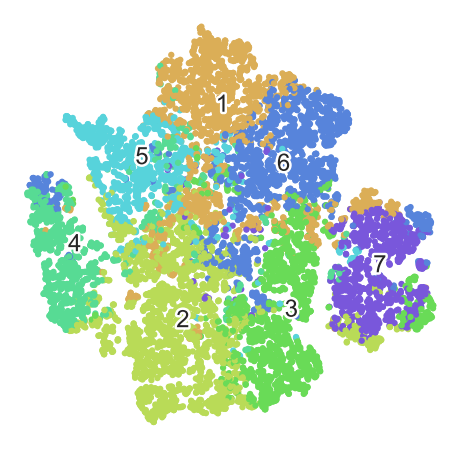

In [652]:
scatter(digits_proj, y);

#### Word Clouds

In [499]:
product_topic_nmf_all.head()

,1,2,3,4,5,6,7,brand_name,review
Être Pour Homme Cologne,0.03082,0.00000,0.03822,0.01408,0.00000,0.00681,0.00539,Lancetti,0.0
Zozo Cologne,0.01086,0.00000,0.00183,0.02228,0.03400,0.01173,0.01298,Ut & C,5.0
Zoa Night Perfume,0.00840,0.02737,0.00000,0.04259,0.01029,0.01765,0.00668,Regines,4.3
Zizonia Cologne,0.05087,0.00000,0.00000,0.00056,0.00000,0.03827,0.05743,Penhaligon's,5.0
Zizanie Cologne,0.05280,0.00000,0.01149,0.00594,0.00000,0.00000,0.00000,Fragonard,4.4


In [500]:
topic_word

array([[0.00000000e+00, 0.00000000e+00, 7.49786234e-04, ...,
        0.00000000e+00, 1.09423181e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.88671973e-04, 0.00000000e+00, 1.23467887e-03],
       [0.00000000e+00, 0.00000000e+00, 1.04717584e-04, ...,
        1.00453811e-04, 0.00000000e+00, 9.46263713e-05],
       ...,
       [6.93319651e-04, 4.70774182e-05, 3.76270711e-04, ...,
        0.00000000e+00, 1.41616634e-04, 0.00000000e+00],
       [7.10244438e-04, 1.69271967e-03, 0.00000000e+00, ...,
        8.44831462e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [501]:
df_word = pd.DataFrame(topic_word.round(5).T,
                       columns = ['1','2','3','4','5','6','7'], 
                       index = vectorizer.get_feature_names())

In [502]:
df_word.head()

,1,2,3,4,5,6,7
aachan,0.00000,0.00000,0.00000,0.0,0.00069,0.00071,0.0
aachen,0.00000,0.00000,0.00000,0.0,0.00005,0.00169,0.0
aagri,0.00075,0.00000,0.00010,0.0,0.00038,0.00000,0.0
aaliyah,0.00000,0.00000,0.00194,0.0,0.00020,0.00114,0.0
aaron,0.00000,0.00029,0.00000,0.0,0.00334,0.00321,0.0


In [503]:
df_word[['1']]

,1
aachan,0.00000
aachen,0.00000
aagri,0.00075
aaliyah,0.00000
aaron,0.00000
...,...
zurich,0.00000
zylberberg,0.00000
éclat,0.00000
édition,0.00109


In [504]:
from wordcloud import WordCloud, STOPWORDS

In [505]:
def top_words(topic, df, num_words):
    df_topic = df[topic]
    return df_topic.sort_values(ascending = False).head(num_words)

In [506]:
topic1 = top_words('1', df_word, 10).to_dict()

In [507]:
topic1

{'spicy': 0.99645,
 'patchouli': 0.69379,
 'woody': 0.66532,
 'black': 0.63187,
 'oud': 0.57582,
 'warm': 0.56389,
 'blend': 0.56056,
 'wood': 0.54147,
 'leather': 0.49311,
 'oriental': 0.47969}

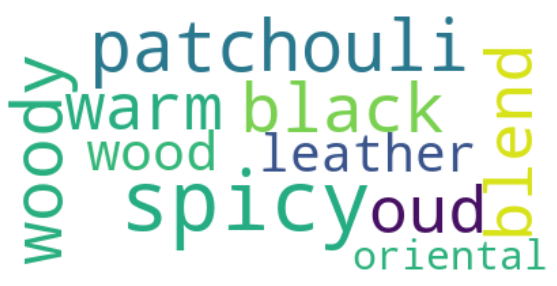

In [508]:
wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(topic1)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [509]:
topic2 = top_words('2', df_word, 10).to_dict()

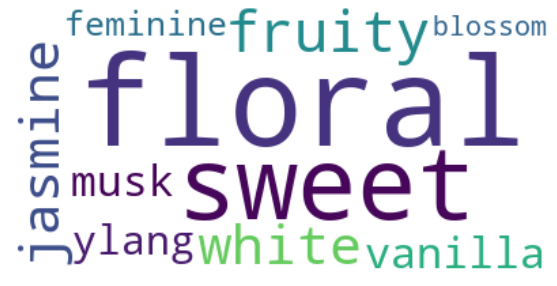

In [510]:
wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(topic2)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [511]:
topic3 = top_words('3', df_word, 10).to_dict()

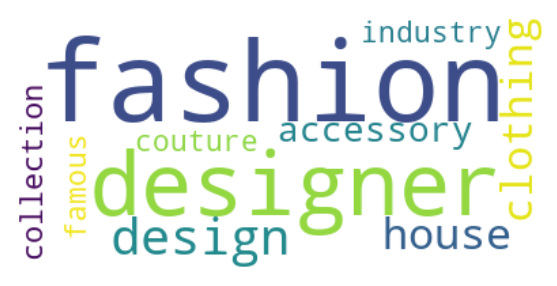

In [512]:
wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(topic3)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

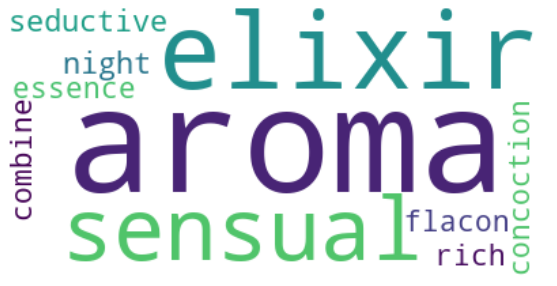

In [513]:
topic4 = top_words('4', df_word, 10).to_dict()

wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(topic4)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

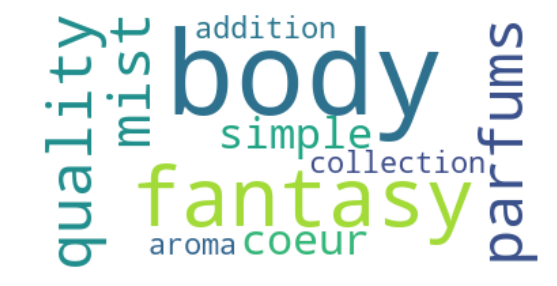

In [514]:
topic5 = top_words('5', df_word, 10).to_dict()

wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(topic5)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

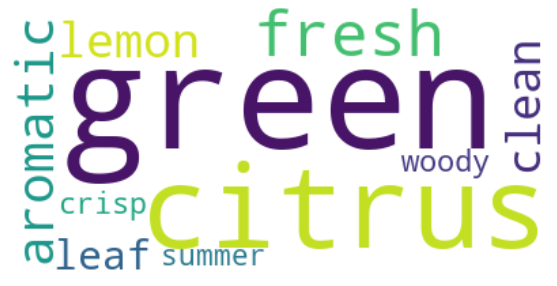

In [515]:
topic6 = top_words('6', df_word, 10).to_dict()

wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(topic6)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

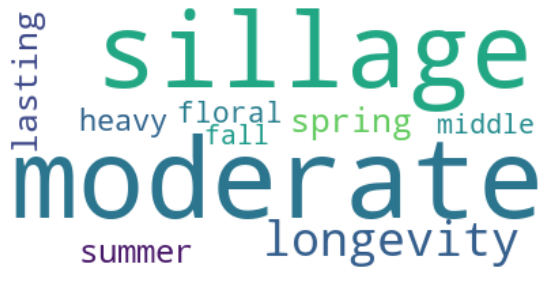

In [516]:
topic7 = top_words('7', df_word, 10).to_dict()

wc = WordCloud(background_color="white", max_words=10).generate_from_frequencies(topic7)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [518]:
with open('df_desc.pickle', 'wb') as to_write:
    pickle.dump(df_desc, to_write)


In [739]:
#check the most frequent words
words_list = [word for doc in tmp.token for word in doc]

ct = Counter(words_list).most_common(10)

In [740]:
ct.sort(key=lambda x: x[1], reverse=False) 

In [741]:
ct_df = pd.DataFrame(ct)

In [742]:
ct_df.iloc[:,1]

0    4318
1    4559
2    4635
3    5142
4    5281
5    5380
6    6438
7    6508
8    8476
9    8642
Name: 1, dtype: int64

In [743]:
from matplotlib.pyplot import figure

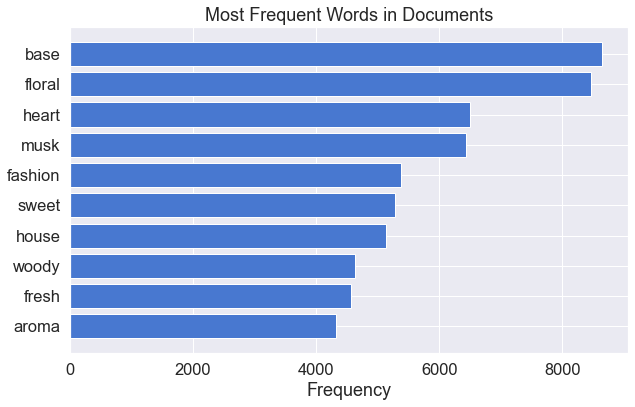

In [745]:
word = list(zip(*ct))[0]
freq = list(zip(*ct))[1]
x_pos = np.arange(len(word)) 

figure(figsize = (10,6))
plt.barh(x_pos, freq,align='center')

plt.title('Most Frequent Words in Documents')
plt.yticks(x_pos, word) 
plt.xlabel('Frequency')
plt.show()